In [ ]:
# standard loads
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore
import pandas as pd #type:ignore
import os
import glob
import json
import h5py #type:ignore
from skimage import morphology #type:ignore
from skimage.morphology import skeletonize #type:ignore
from skimage.morphology import dilation, disk # type: ignore


# import specific algorithm functions
from input_formatting import input_formatting # * imports all functions from the referenced .py file
from Strahler_Correction_class import CreekNetworkAnalyzer
from Creek_Repair import process_creek_mask, save_creek_mask_h5, load_creek_mask_h5, process_creek_mask_diagnostic

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

### input_formatting

In [2]:
# input_formatting
# formats elevation and slope raster ascii files in to .h5
# requires user manual input for filename of elevation and slope

print('Elevation Files:')
# Change file names for specific site - i.e., filename = 'INPUTS/blahblah_elev.txt' or 'INPUTS/blahblah_slope.txt'
filename_elev = 'INPUTS/av_DEM_converted_m_fillNoData.asc' # user input
filename_out_elev, filename_out_meta_elev = input_formatting(filename_elev)
print('File was saved as: ', filename_out_elev)
print('Metadata file was saved as: ', filename_out_meta_elev)

print('')

print('Slope Files:')
filename_slope = 'INPUTS/av_slope_degrees_fillNoData.asc' # user input
filename_out_slope, filename_out_meta_slope = input_formatting(filename_slope)
print('File was saved as: ', filename_out_slope)
print('Metadata file was saved as: ', filename_out_meta_slope)

Elevation Files:
ncols: 392.0
nrows: 401.0
x corner: 704509.4
y corner: 107140.8
cell size: 1.0
NoData value: -340282346638528859811704183484516925440.0
File was saved as:  INPUTS/av_DEM_converted_m_fillNoData.h5
Metadata file was saved as:  INPUTS/av_DEM_converted_m_fillNoData_metadata.h5

Slope Files:
ncols: 392.0
nrows: 401.0
x corner: 704509.4
y corner: 107140.8
cell size: 1.0
NoData value: -9999.0
File was saved as:  INPUTS/av_slope_degrees_fillNoData.h5
Metadata file was saved as:  INPUTS/av_slope_degrees_fillNoData_metadata.h5


### CHIROL_CREEK_ALGORITHM

In [3]:
# Section 1 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/13

import time

# import specific algorithm functions
from readvardef import readvardef

start_time = time.time()

# 1) User to select input variables
figview = 0  # Change to 1 to see additional figures

# Open User Variables instruction file
filename_UserVar = '/Users/sam/RDE Dropbox/Projects/22386.Ashleyville Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM/INPUTS/UserVar_av.txt' # manual input, as opposed to MATLAB script's GUI selection
result = readvardef(filename_UserVar)
if result is None:
    print("User aborted or error occurred.")
    exit()

FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION = result

# Unpack data from global variables
name = FILENAMES["name"]
elev = FILENAMES["elev"]
elevmeta = FILENAMES["elevmeta"]
slope = FILENAMES["slope"]
slopemeta = FILENAMES["slopemeta"]

resamplestep = PROCESSING["resamplestep"]
threshold = PROCESSING["threshold"]
detrendyn = PROCESSING["detrendyn"]
outletdetection = PROCESSING["outletdetection"]

HAT = TIDE["HAT"]
MHWS = TIDE["MHWS"]
MHWN = TIDE["MHWN"]
MLWS = TIDE["MLWS"]
MLWN = TIDE["MLWN"]

Cth = THRESHOLDS["Cth"]
Ctharea = THRESHOLDS["Ctharea"]
LZth = THRESHOLDS["LZth"]
LZtharea = THRESHOLDS["LZtharea"]
HZth = THRESHOLDS["HZth"]
HZtharea = THRESHOLDS["HZtharea"]

nbbreaches = RECONNECTION["nbbreaches"]
noisethreshold = RECONNECTION["noisethreshold"]
reconnect = RECONNECTION["reconnect"]
reconnectiondist = RECONNECTION["reconnectiondist"]
ordermax = RECONNECTION["ordermax"]
filtersmall1 = RECONNECTION["filtersmall1"]
filterlarge1 = RECONNECTION["filterlarge1"]
smoothing = RECONNECTION["smoothing"]
connectivity = RECONNECTION["connectivity"]
holesizeinfill = RECONNECTION["holesizeinfill"]
filtersmall2 = RECONNECTION["filtersmall2"]
filterlarge2 = RECONNECTION["filterlarge2"]

#  Print out the values to verify they were read correctly
# print("Loaded variables:")
# for category in [FILENAMES, PROCESSING, TIDE, THRESHOLDS, RECONNECTION]:
#     for key, value in category.items():
#         print(f"{key}: {value}")

end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")

In [4]:
# Section 2 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/15

# import specific algorithm functions
from Loadlidarmaps import Loadlidarmaps
from RemoveaboveHAT import RemoveaboveHAT

# Load the data
Xs, Ys, Zs, X, Y, Z, gs, xc, yc = Loadlidarmaps(elev, elevmeta, slope, slopemeta)

# Remove values above HAT
Z, Zs, meandepth, meanslope = RemoveaboveHAT(Z, Zs, HAT, detrendyn)

# Print some information about the loaded and processed data
print(f"Data loaded and processed:")
print(f"X range: {np.min(X)} to {np.max(X)} meters")
print(f"Y range: {np.min(Y)} to {np.max(Y)} meters")
print(f"Z range: {np.nanmin(Z)} to {np.nanmax(Z)} meters")
print(f"Mean depth: {meandepth} meters")
print(f"Mean slope: {meanslope} degrees")
print(f"Grid size: {gs} meters")

# Subsample the dataset to make mapping quicker
# X2 = X[::resamplestep, ::resamplestep]
# Y2 = Y[::resamplestep, ::resamplestep]
X2 = X[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Y2 = Y[::resamplestep] # was 2D in MATLAB, I guess not 2D in Python?
Z2 = Z[::resamplestep, ::resamplestep]

print(f"Subsampled data shape: {Z2.shape}")

Data loaded and processed:
X range: 704509.386 to 704900.386 meters
Y range: 107140.822 to 107540.822 meters
Z range: -1.013437032699585 to 2.2827565670013428 meters
Mean depth: 0.4961816064174111 meters
Mean slope: 2.4339671037132393 degrees
Grid size: 1.0 meters
Subsampled data shape: (196, 201)


In [5]:
# Section 3 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/09/15 and 2024/10/10

# Your variables
variables_detection = {
    "threshold": threshold,
    "Zs": Zs.tolist(),   # Convert arrays to lists to make them JSON serializable
    "Z": Z.tolist(),
    "gs": gs,
    "X": X,
    "Y": Y,
    "X2": X2,
    "Y2": Y2,
    "Z2": Z2,
    "LZtharea": LZtharea,
    "LZth": LZth,
    "HZtharea": HZtharea,
    "HZth": HZth,
    "Ctharea": Ctharea,
    "Cth": Cth
}

# Convert all numpy arrays to lists
variables_detection = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in variables_detection.items()}

# Save to a JSON file
with open("variables_Creek_Detection.json", "w") as f:
    json.dump(variables_detection, f)

# After running this cell, you need to run in terminal, following these steps: <br>
# 1) If you're on macOS or Linux, make sure that Tkinter (which matplotlib uses for plotting) is properly installed. 
#     On macOS, you can install it via Homebrew using: <br>
#     ```brew install python-tk```

#     NOTE: Homebrew is a package manager for macOS (and Linux)
#       that simplifies the process of installing, updating, and managing software and tools on your system.
# 2) Open terminal (Command Prompt in Windows)
# 3) Change current directory to folder containing creek extraction .py files - the "~" is to reference your user local folder
#     (spaces in filepath need to be preceded by a single backslash \ to not break up continuous filepath): <br>
#      ```cd ~/RDE\ Dropbox/Projects/22386.Ashleyville\ Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM```
# 4) Run .py file:  <br>
#     ```python Creek_Detection.py```
# 5) Plots should appear in python GUI windows - you can adjust plot positioning in this window, and save the figures. 
#       If the threshold value is 1, you will be prompted to click GUI plots of slope and hypsometry.
# 6) As instructed in terminal print statement, press Enter (return) key to close plots.

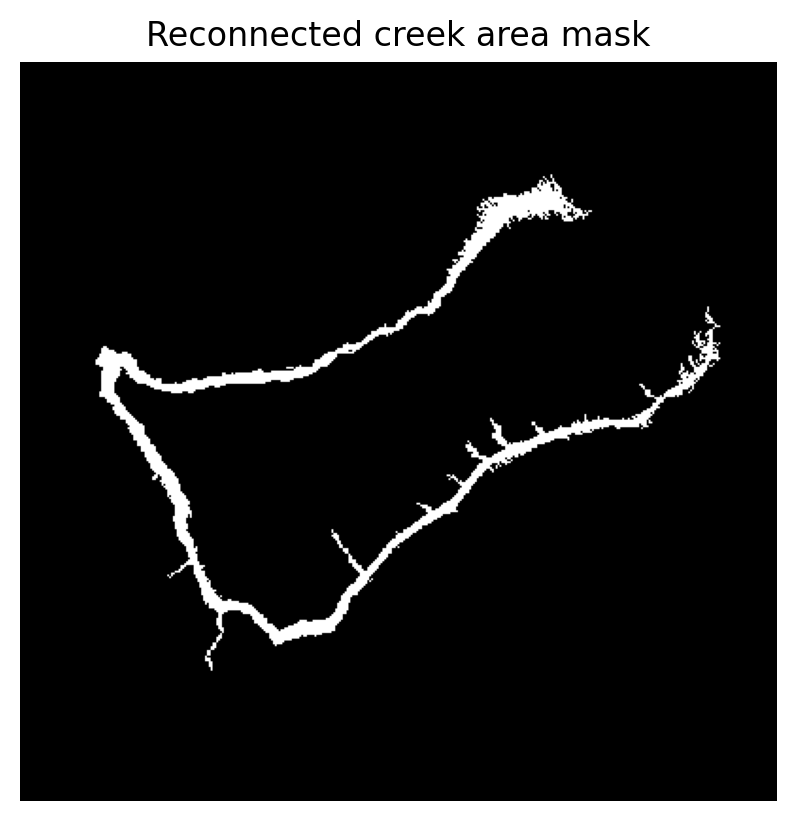

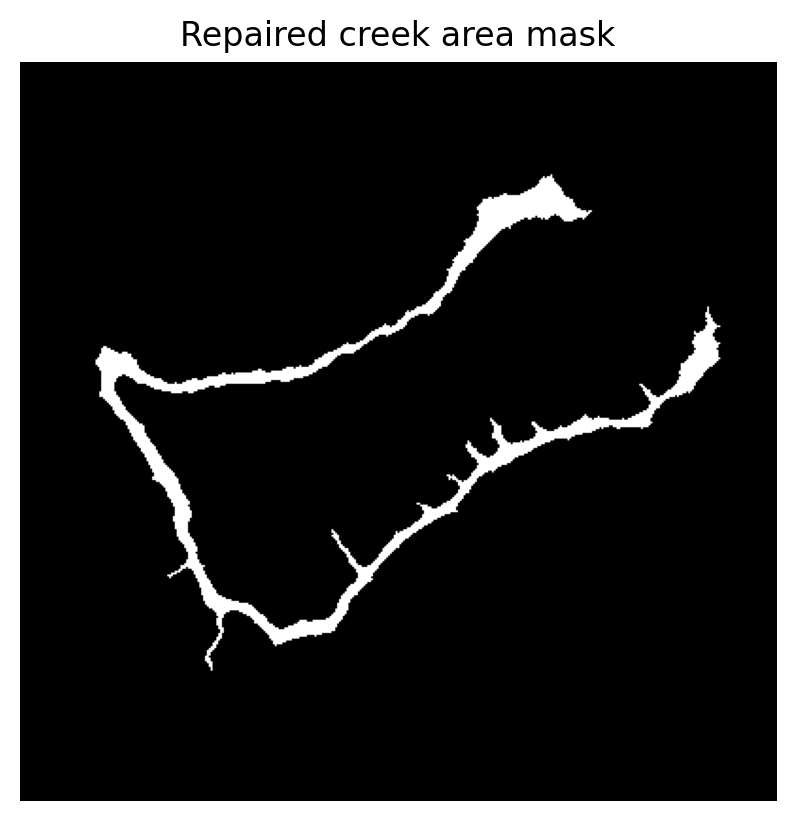

In [6]:
# Section 4 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI and ChatGPT, reviewed by Sam Kraus 2024/10/14

# import specific algorithm functions
from Creek_Repair import process_creek_mask, save_creek_mask_h5, load_creek_mask_h5, process_creek_mask_diagnostic

# load raw creek mask from Step 3
with h5py.File('creekmask_raw.h5', 'r') as hf:
    creekmask_raw = hf['creekmask_raw'][:]
    
# execute functions in Creek_Repair.py and process_creek_mask function
creekmask = process_creek_mask(creekmask_raw, reconnect, noisethreshold, reconnectiondist, connectivity,
                                    filtersmall1, filterlarge1, smoothing, filtersmall2, filterlarge2, holesizeinfill)
# ^the process_creek_mask function inputs differ from the .py file due to use of underscores in .py as opposed to no underscores in .ipynb
save_creek_mask_h5(creekmask, 'creekmask.h5')

# for troubleshooting issues in oversmoothing and filling operations, run diagnostic function with helpful print statements and plots:
# repaired_mask = process_creek_mask_diagnostic(creekmask_raw, reconnect, noisethreshold, reconnectiondist, connectivity,
#                                     filtersmall1, filterlarge1, smoothing, filtersmall2, filterlarge2, holesizeinfill)

In [7]:
# Check imports
# # main_creek_ordering.py
# from Creek_Ordering import check_imports

#  # Check imports and functionality
# if not check_imports():
#     print("Error: Required imports not available")

In [8]:
# Section 5 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed line-by-line by Sam Kraus 2024/11/25

# import specific algorithm functions
from Creek_Ordering import figure_creek_skeleton, process_creek_ordering, process_creek_ordering_diagnostic
# from Creek_Ordering import figure_creek_skeleton, process_creek_ordering_diagnostic


# load raw creek mask from Step 4
creekmask = load_creek_mask_h5('creekmask.h5')
# with h5py.File('creekmask.h5', 'r') as hf:
#     creekmask_raw = hf['creek_mask'][:]

# prep data for functions
skeleton = morphology.skeletonize(creekmask)
# figure_creek_skeleton(skeleton)

# execute functions in Creek_Ordering.py
STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = process_creek_ordering(ordermax, Z, skeleton, outletdetection, nbbreaches)
# diagnostic version - uncomment and run for debugging:
# results_ordering = process_creek_ordering_diagnostic(ordermax, Z, skeleton, outletdetection, nbbreaches)
# STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = results_ordering

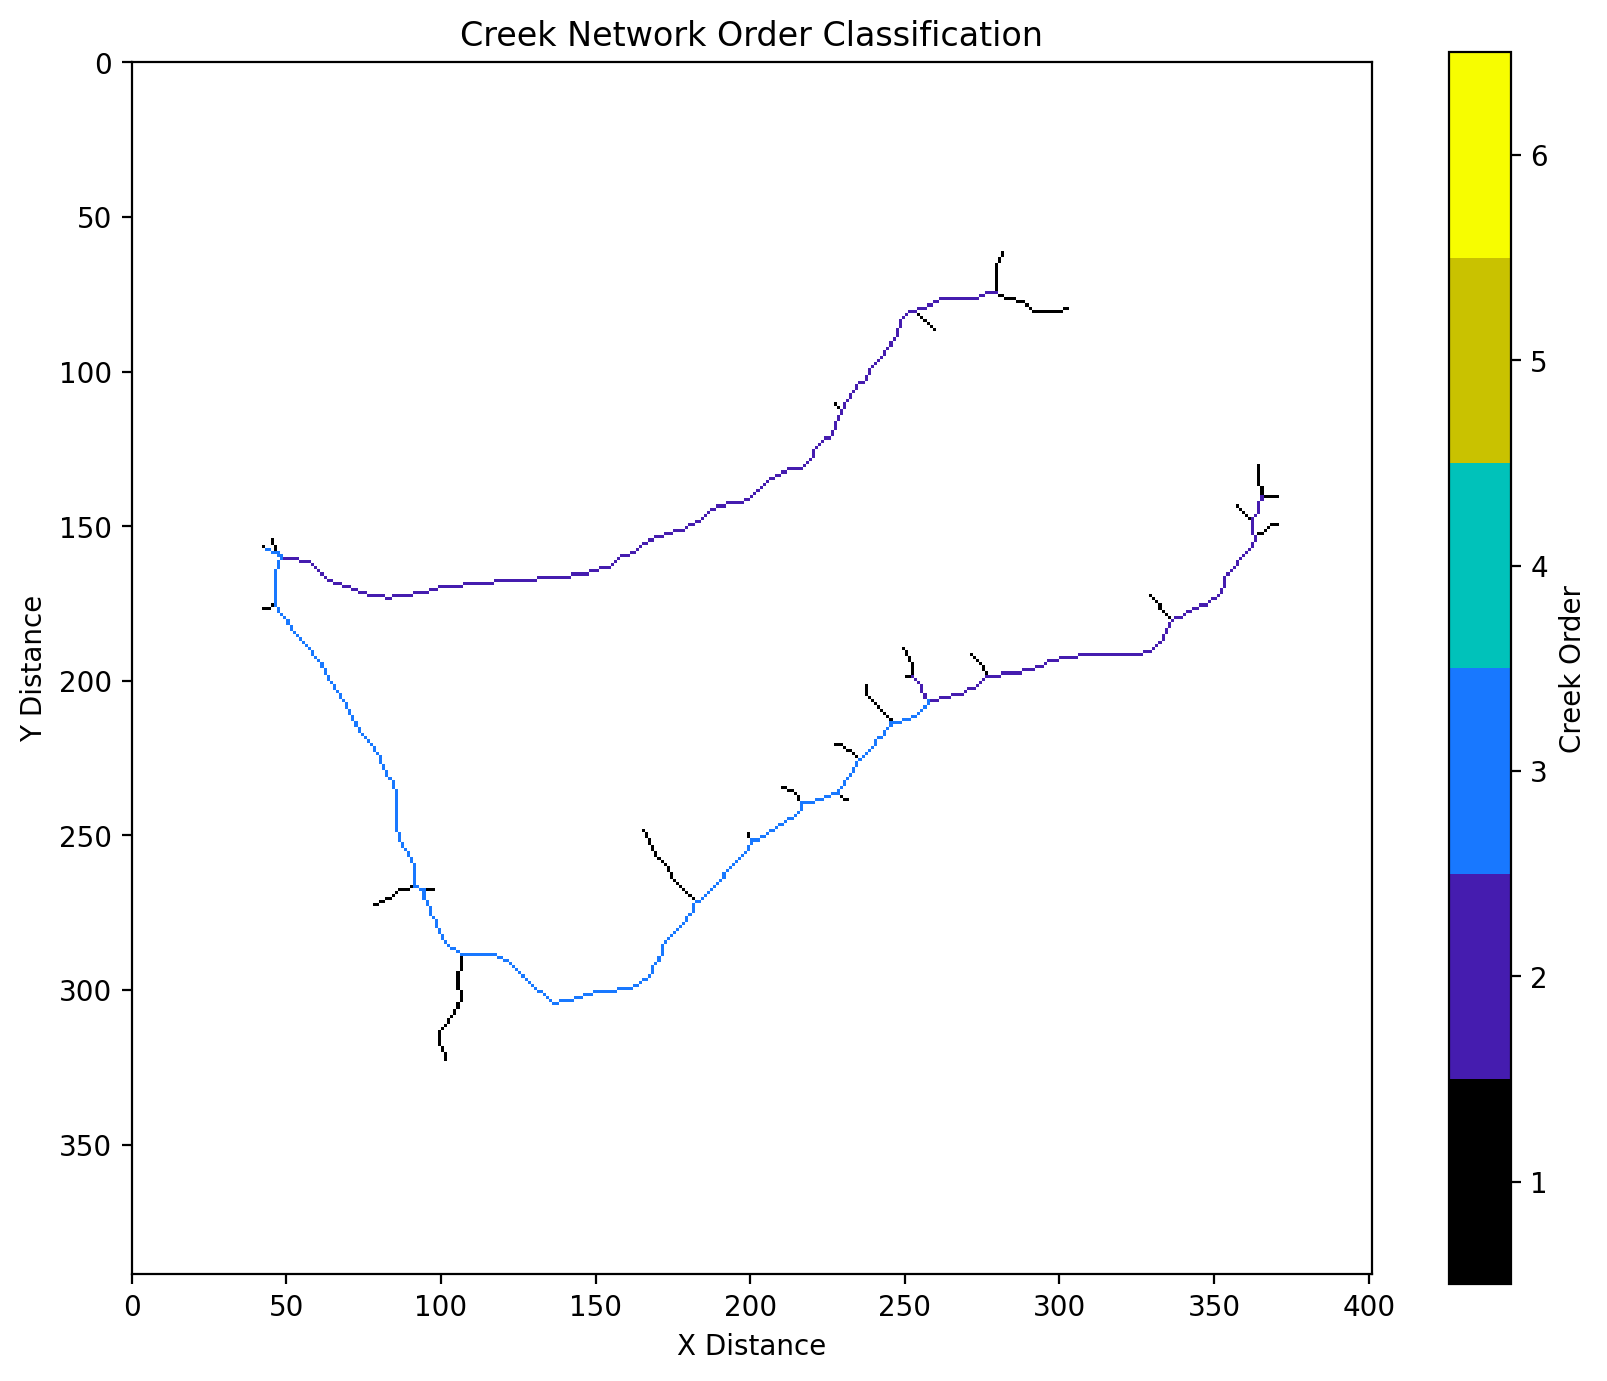

In [ ]:
# check creek orders
import numpy as np #type:ignore 
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore

def plot_creek_orders(skeleton, creekorder, X=None, Y=None, colors=None, figsize=(10, 8), dpi=100):
    # Input validation
    if not isinstance(skeleton, np.ndarray) or not isinstance(creekorder, np.ndarray):
        raise ValueError("skeleton and creekorder must be numpy arrays")
    
    if skeleton.shape != creekorder.shape:
        raise ValueError("skeleton and creekorder must have the same shape")
        
    # Default color scheme if none provided
    if colors is None:
        colors = ['#000000',  # Black for order 1
                 '#451caf',  # Deep purple for order 2
                 '#1878ff',  # Blue for order 3
                 '#00c2ba',  # Turquoise for order 4
                 '#c9c200',  # Yellow-green for order 5
                 '#f7fd00']  # Bright yellow for order 6
    
    discrete_cmap = ListedColormap(colors)
    
    # Create coordinate arrays if not provided
    if X is None or Y is None:
        ny, nx = skeleton.shape
        # Create coordinates with one more point than the data dimensions
        x = np.arange(nx + 1)
        y = np.arange(ny + 1)
        X, Y = np.meshgrid(x, y)
    else:
        # If coordinates are provided, verify/adjust their dimensions
        if X.shape[0] != skeleton.shape[0] + 1 or X.shape[1] != skeleton.shape[1] + 1:
            # Adjust coordinates to have one more point than the data
            x = np.linspace(X.min(), X.max(), skeleton.shape[1] + 1)
            y = np.linspace(Y.min(), Y.max(), skeleton.shape[0] + 1)
            X, Y = np.meshgrid(x, y)
    
    # Mask the creek orders
    masked_orders = np.ma.masked_where(~skeleton, creekorder)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Set the aspect ratio to 1:1
    ax.set_aspect('equal')
    
    # Plot the data using pcolormesh with explicit shading parameter
    im = ax.pcolormesh(X, Y, masked_orders, 
                      cmap=discrete_cmap, 
                      vmin=1, 
                      vmax=len(colors) + 1,
                      shading='flat')
    
    # Add and customize the colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Creek Order', fontsize=10)
    
    # Center the colorbar ticks between colors
    cbar.set_ticks(np.arange(1.5, len(colors) + 1.5))
    cbar.set_ticklabels(np.arange(1, len(colors) + 1))
    
    # Add labels and title
    ax.set_xlabel('X Distance')
    ax.set_ylabel('Y Distance')
    ax.set_title('Creek Network Order Classification')
    
    # Invert the y-axis for traditional GIS visualization
    ax.invert_yaxis()
    
    return fig, ax


# Plot the sample data
fig, ax = plot_creek_orders(skeleton_breached, creekordersing)
plt.show()

In [10]:
# Ashleyville Marsh outlet at y,x = 156,42
print(creekordersing[155:158,41:44])
# print(skeleton[155:158,41:44])
print(skeleton_breached[155:158,41:44])

[[0 0 0]
 [0 0 0]
 [0 0 3]]
[[False False False]
 [False  True False]
 [False False  True]]


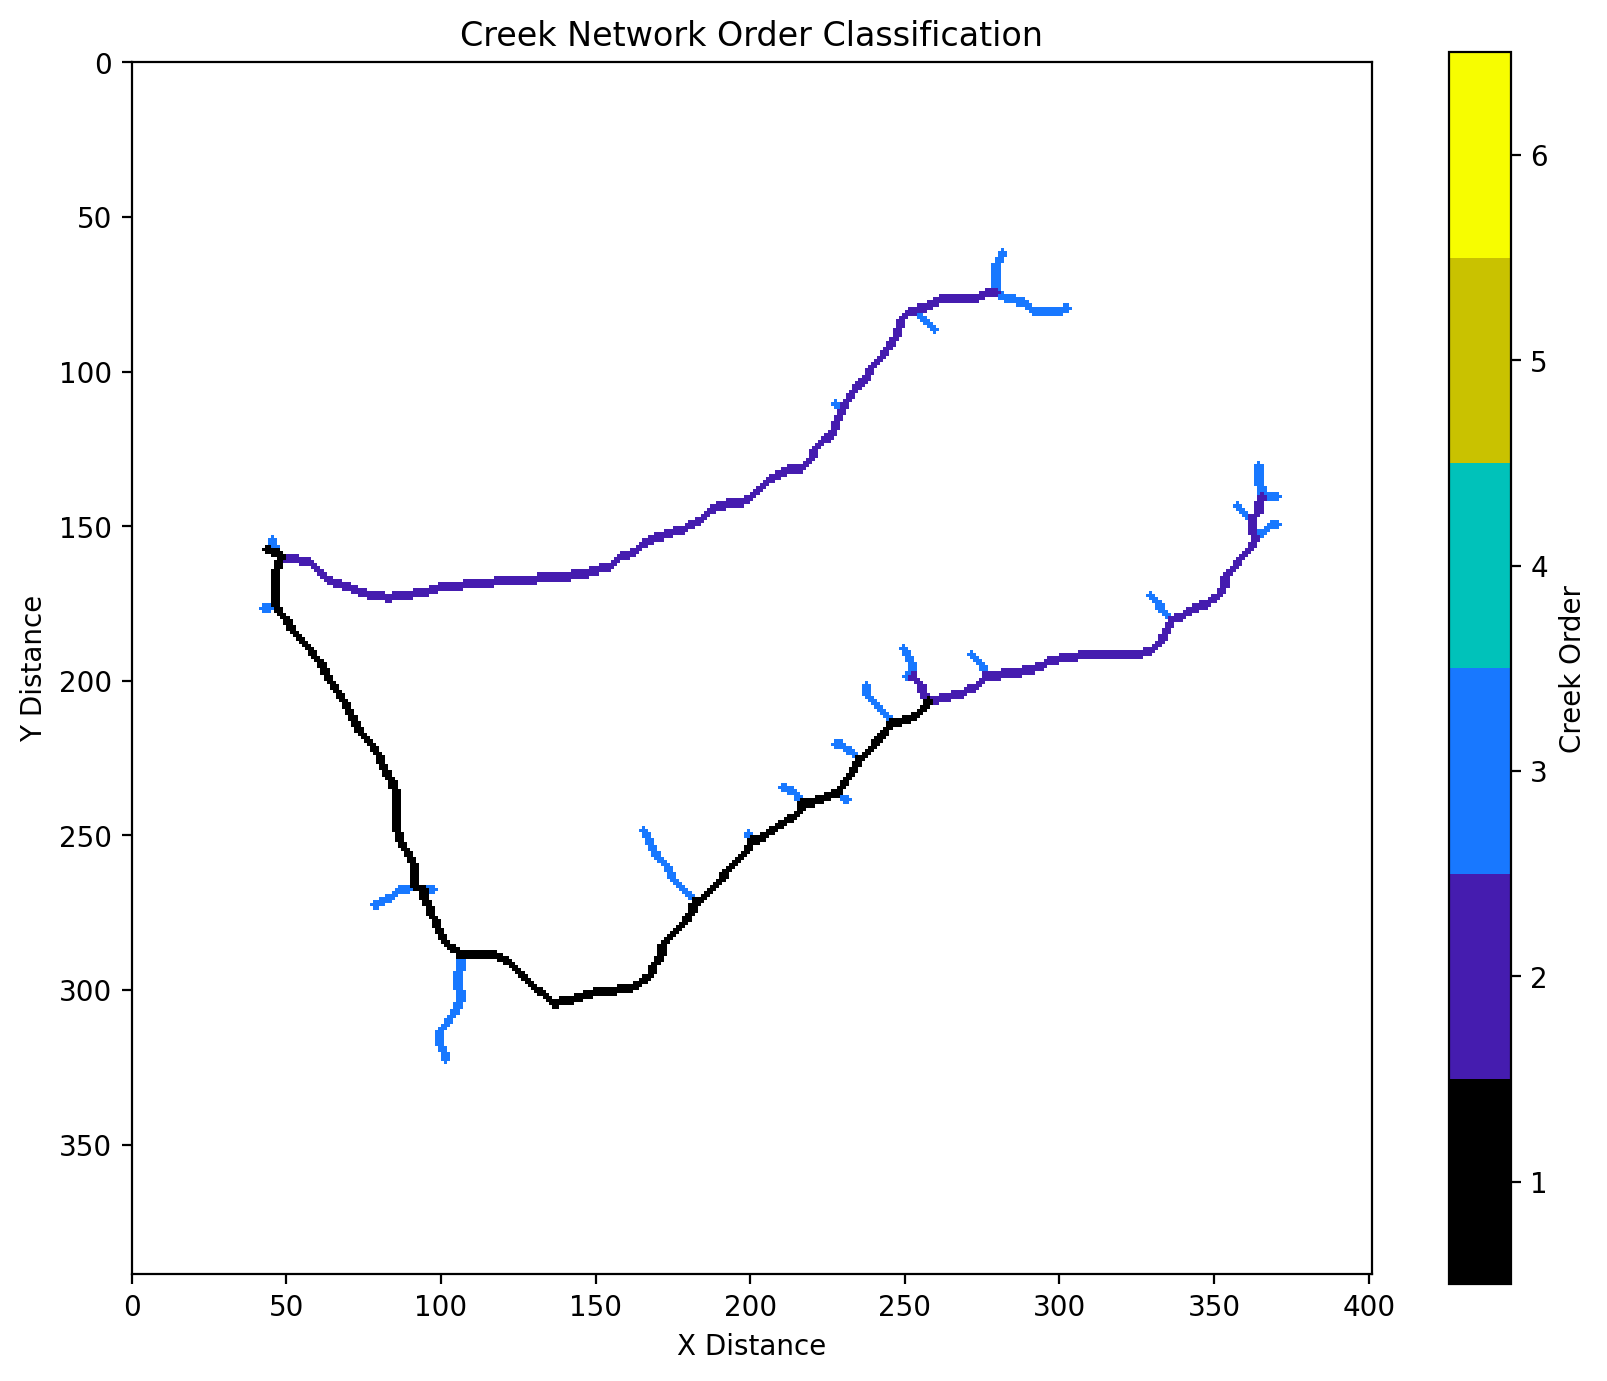

In [ ]:
# check creek orders thickened skeleton
import numpy as np #type:ignore 
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore
from skimage.morphology import dilation, disk # type: ignore

def convert_to_numpy(data, dtype=None):
    """Safely convert input data to numpy array"""
    try:
        if isinstance(data, list):
            # Handle nested lists by converting inner lists first
            if data and isinstance(data[0], list):
                data = [np.array(row) for row in data]
        return np.array(data, dtype=dtype)
    except Exception as e:
        print(f"Error converting data to numpy array: {e}")
        print("Data sample:", data[:2] if isinstance(data, list) else data)
        raise

def plot_creek_orders_big(skeleton, creekorder, X, Y, colors, figsize, dpi):
    """Plot creek orders"""

    np.savetxt("ipynb_creek_order_pre_convert.csv", creekorder, delimiter=",", fmt="%.2f")
    creekorder = convert_to_numpy(creekorder, dtype=float)
    np.savetxt("ipynb_creek_order_post_convert.csv", creekorder, delimiter=",", fmt="%.2f")

    # Create coordinate arrays if not provided
    if X is None or Y is None:
        ny, nx = skeleton.shape
        # Create coordinates with one more point than the data dimensions
        x = np.arange(nx + 1)
        y = np.arange(ny + 1)
        X, Y = np.meshgrid(x, y)
    else:
        # If coordinates are provided, verify/adjust their dimensions
        if X.shape[0] != skeleton.shape[0] + 1 or X.shape[1] != skeleton.shape[1] + 1:
            # Adjust coordinates to have one more point than the data
            x = np.linspace(X.min(), X.max(), skeleton.shape[1] + 1)
            y = np.linspace(Y.min(), Y.max(), skeleton.shape[0] + 1)
            X, Y = np.meshgrid(x, y)
            
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Set the aspect ratio to 1:1
    ax.set_aspect('equal')
    # ax1.clear()

    # Create discrete colormap: black + 5 colors
    # Define the 5 colors you want to use
    colors = ['#000000', '#451caf', '#1878ff', '#00c2ba', '#c9c200', '#f7fd00']
    # Create the discrete colormap
    discrete_cmap = ListedColormap(colors)

    # Dilate the skeleton for better visibility
    np.savetxt("ipynb_skeleton.csv", skeleton, delimiter=",", fmt="%.2f")
    dilated_skeleton = dilation(skeleton, disk(1))
    np.savetxt("ipynb_dilated_skeleton.csv", dilated_skeleton, delimiter=",", fmt="%.2f")
    # dilated_skeleton = dilation(dilated_skeleton, disk(1))
    # dilated_skeleton = bwmorph_thicken(skeleton, 1)

    # Swap creek orders from Strahler to Reverse Strahler
    creekorder[creekorder == 0] = np.nan
    max_order = np.full_like(creekorder, float(ordermax + 1))
    max_order = max_order.astype(float)  # Ensure max_order is float
    max_order[np.isnan(creekorder)] = np.nan
    creek_order_swapped = max_order - creekorder

    # Dilate the creek order mask for better visibility
    np.savetxt("ipynb_creek_order_swapped.csv", creek_order_swapped, delimiter=",", fmt="%.2f")
    # masked_orders = np.ma.masked_where(~dilated_skeleton, creekorder)
    masked_orders = np.ma.masked_where(~dilated_skeleton, creek_order_swapped)

    # Plot the data using pcolormesh with explicit shading parameter
    np.savetxt("ipynb_X.csv", X, delimiter=",", fmt="%.2f")
    np.savetxt("ipynb_Y.csv", Y, delimiter=",", fmt="%.2f")
    im = ax.pcolormesh(X, Y, masked_orders, 
                      cmap=discrete_cmap, 
                      vmin=1, 
                      vmax=len(colors) + 1,
                      shading='flat')
    
    # Add and customize the colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Creek Order', fontsize=10)
    
    # Center the colorbar ticks between colors
    cbar.set_ticks(np.arange(1.5, len(colors) + 1.5))
    cbar.set_ticklabels(np.arange(1, len(colors) + 1))
    
    # Add labels and title
    ax.set_xlabel('X Distance')
    ax.set_ylabel('Y Distance')
    ax.set_title('Creek Network Order Classification')
    
    # Invert the y-axis for traditional GIS visualization
    ax.invert_yaxis()
    
    return fig, ax


# Plot the sample data
fig, ax = plot_creek_orders_big(skeleton_breached, creekorder, X=None, Y=None, colors=None, figsize=(10, 8), dpi=100)
plt.show()

In [ ]:
# Section 6 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus 2024/12/15

import numpy as np #type:ignore
import json
from skimage.morphology import skeletonize #type:ignore
from Strahler_Correction_class import CreekNetworkAnalyzer

# Your variables
variables_correction = {
    "skeleton": skeleton_breached,
    "X": X,
    "Y": Y,
    "creek_order": creekorder,
    "creek_order_single": creekordersing,
    "pts": PTS,
    "order_max": ordermax,
    "STRAHLER": STRAHLER,
    "STRAIGHTDIST": STRAIGHTDIST,
    "IDXBRANCH": IDXBRANCH,
    "IDXSEG": IDXSEG
}

# Convert all numpy arrays to lists
variables_correction = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in variables_correction.items()}

# Save to a JSON file
with open("variables_Strahler_Correction.json", "w") as f:
    json.dump(variables_correction, f)

# After running this cell, you need to run in terminal, following these steps: <br>
# 1) If you're on macOS or Linux, make sure that Tkinter (which matplotlib uses for plotting) is properly installed. 
#     On macOS, you can install it via Homebrew using: <br>
#     ```brew install python-tk```
#     NOTE: Homebrew is a package manager for macOS (and Linux)
#       that simplifies the process of installing, updating, and managing software and tools on your system.
# 2) Open terminal (Command Prompt in Windows)
# 3) Change current directory to folder containing creek correction .py files - the "~" is to reference your user local folder
#     (spaces in filepath need to be preceded by a single backslash \ to not break up continuous filepath): <br>
#      ```cd ~/RDE\ Dropbox/Projects/22386.Ashleyville\ Marsh/WORK/CODE/Python/CHIROL_CREEK_EXTRACTION_ALGORITHM```
# 4) Run .py file:  <br>
#     ```python Strahler_Correction_execute.py```
# 5) Plots should appear in python GUI windows - you can adjust plot positioning in this window, and save the figures. 
#       Follow the GUI instructions to correct loops.
# 6) Click the "Finish Correction" button after finishing ALL corrections

In [ ]:
# Section 7 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed by Sam Kraus DATE
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
import h5py

def process_creek_orders(STRAHLER, STRAIGHTDIST, Z, X, Y, creekorder2, ID, name):
    # Calculate sinuosity
    SINUOSITY = np.divide(STRAHLER, STRAIGHTDIST, where=(STRAIGHTDIST!=0))
    
    # Remove rows and columns of zeros
    # Find indices where rows/columns are not all zeros
    rows_to_keep = np.any(STRAHLER, axis=1)
    cols_to_keep = np.any(STRAHLER, axis=0)
    
    # Filter arrays
    SINUOSITY = SINUOSITY[rows_to_keep][:, cols_to_keep]
    STRAIGHTDIST = STRAIGHTDIST[rows_to_keep][:, cols_to_keep]
    STRAHLER = STRAHLER[rows_to_keep][:, cols_to_keep]
    
    # Get number of segments (count non-zero elements in each row)
    SEGMENTS = np.sum(STRAHLER != 0, axis=1)
    
    # Create SINUOUSLENGTH with same shape as STRAHLER
    SINUOUSLENGTH = STRAHLER.copy()
    
    # Reverse ID array
    ID = np.flip(ID)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Create contour mask
    contourmask = ~np.isnan(Z)
    # Fill holes
    contourmask = ndimage.binary_fill_holes(contourmask)
    
    # Morphological operations
    contourmask = morphology.binary_closing(contourmask)
    contourmask = morphology.thin(contourmask)  # equivalent to 'remove' in MATLAB
    # Note: 'diag' operation doesn't have direct equivalent in skimage
    contourmask = morphology.dilation(contourmask)  # equivalent to 'thicken'
    
    # Create custom colormap
    colors = np.vstack(([0, 0, 0], plt.cm.parula(np.linspace(0, 1, 5))))
    plt.set_cmap(plt.ListedColormap(colors))
    
    # Plot pcolor equivalent
    plt.pcolormesh(X, Y, creekorder2, shading='auto')
    plt.clim(1, 7)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Creek order', fontsize=16, fontweight='bold')
    cbar.set_ticks([1, 2, 3, 4, 5, 6])
    
    # Set font properties
    plt.gca().tick_params(labelsize=16)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')
    
    # Save creek mask to HDF5 format
    output_filename = f'OUTPUTS/{name}_creekorder.h5'
    with h5py.File(output_filename, 'w') as f:
        # Create a dataset in the HDF5 file
        f.create_dataset('creekorder2', data=creekorder2, compression='gzip', compression_opts=9)
        
        # Add metadata if needed
        f.attrs['creation_date'] = str(np.datetime64('now'))
        f.attrs['description'] = 'Creek order analysis results'
    
    return SINUOSITY, STRAIGHTDIST, STRAHLER, SEGMENTS, SINUOUSLENGTH

# Example usage:
# result = process_creek_orders(STRAHLER, STRAIGHTDIST, Z, X, Y, creekorder2, ID, name)